In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
import keras.backend as K
from tensorflow.keras import losses
import keras.utils
import tensorflow as tf
import pandas as pd

from tqdm import tqdm
import chipwhisperer as cw
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Dark2_5 as palette
import itertools
import datetime
import time
import h5py

In [2]:
Sbox = [
0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]

HW       = np.array([ 0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8 ]).astype(np.int8)

In [3]:
Global = open('./AVR_AES_v1_opts_50000tr_3520p_randPT.trace', 'rb')

Header = Global.read(32)

temp = int.from_bytes(Header[20:24], 'little')
nTraceNum = np.uint32(temp)
print("# of preprocessed traces: %d" % nTraceNum)

temp = int.from_bytes(Header[24:28], 'little')
nTraceLen = np.uint32(temp)
print("# of preprocessed points: %d" % nTraceLen)

Trace = np.fromfile(Global, np.float32)
Trace = Trace.reshape(nTraceNum, nTraceLen)

Global.close()

# of preprocessed traces: 50000
# of preprocessed points: 3520


In [4]:
Trace = Trace[:, 800:1500]

In [5]:
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(Trace[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, Trace[i], color=color)
show(p)

Loading BokehJS ...

In [6]:
# 전처리 파형 중 일부사용
simul_trace_normal = np.array(Trace[:], dtype='float64')
for i in range(len(Trace)):
    simul_trace_normal[i] -= simul_trace_normal[i].mean()
    MIN = min(simul_trace_normal[i])
    MAX = max(simul_trace_normal[i])
    simul_trace_normal[i] = ((simul_trace_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2
    
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(simul_trace_normal[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, simul_trace_normal[i], color=color)
show(p)

Loading BokehJS ...

In [7]:
temp = np.genfromtxt('./AVR_AES_v1_opts_50000tr_3520p_randPT_plain.txt', dtype='|S8')

Plain_pre = []
for i in range(temp.shape[0]):
    Plain_pre.append([])
    for j in range(temp.shape[1]):
        Plain_pre[i].append(int(temp[i][j].decode("utf-8"), 16))
pt = np.array(Plain_pre)


temp = np.genfromtxt('./AVR_AES_v1_opts_50000tr_3520p_randPT_key.txt', dtype='|S8')

Key_pre = []
for i in range(temp.shape[0]):
    Key_pre.append([])
    for j in range(temp.shape[1]):
        Key_pre[i].append(int(temp[i][j].decode("utf-8"), 16))
key = np.array(Key_pre)

In [8]:
simul_pt = pt[:][:]
simul_key = key[:][:]
print(simul_pt.shape)

(50000, 16)


In [9]:
simul_pt = np.concatenate([simul_pt[:, 0:1], simul_pt[:, 5:6]], axis = 1)
simul_key = np.concatenate([simul_key[:, 0:1], simul_key[:, 5:6]], axis = 1)

In [10]:
simul_pt

array([[ 61,  71],
       [ 18, 192],
       [148,  44],
       ...,
       [112, 195],
       [113,  52],
       [109,  35]])

In [11]:
simul_key

array([[  1, 171],
       [  1, 171],
       [  1, 171],
       ...,
       [  1, 171],
       [  1, 171],
       [  1, 171]])

In [12]:
simul_trace_normal.shape

(50000, 700)

In [49]:
a = simul_trace_normal[:, 60:80]
b = simul_trace_normal[:, 250:270]

In [50]:
for i in range(20):
    for j in range(20):
        if (i==0 and j==0):
            so_simul_trace = np.array([abs(a[:, i] - b[:, j])])
        else:
            tmp = np.array([abs(a[:, i] - b[:, j])])
            so_simul_trace = np.concatenate((so_simul_trace, tmp), axis=0)
so_simul_trace = np.transpose(so_simul_trace)
#so_simul_trace = np.fabs(so_simul_trace)
print(so_simul_trace.shape)

(50000, 400)


In [51]:
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(so_simul_trace[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, so_simul_trace[i], color=color)
show(p)

Loading BokehJS ...

In [52]:
# 전처리 파형 중 일부사용
so_simul_trace_normal = np.array(so_simul_trace[:], dtype='float64')
for i in range(len(so_simul_trace)):
    so_simul_trace_normal[i] -= so_simul_trace_normal[i].mean()
    MIN = min(so_simul_trace_normal[i])
    MAX = max(so_simul_trace_normal[i])
    so_simul_trace_normal[i] = ((so_simul_trace_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2
    
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(so_simul_trace_normal[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, so_simul_trace_normal[i], color=color)
show(p)

Loading BokehJS ...

In [53]:
def correlation(X, Y):
    X = X - np.mean(X, axis=0)
    Y = Y - np.mean(Y, axis=0)
    return np.sum(X * Y, axis=0) / (np.sqrt(np.sum(np.square(X), axis=0)) * np.sqrt(np.sum(np.square(Y), axis=0)))

def test(trace, plain, bit):
    KeyCorrs  = []
    MaxPeak   = []
    Ratio     = []

    corrs    = []
    maxCorrs = []
    for GuessKey in tqdm(range(43700, 43956)):
        IntermediateValue = HW[(np.array(Sbox)[(plain[:, 0] ^ (GuessKey & 0xff))] ^ np.array(Sbox)[(plain[:, 1] ^ (GuessKey >> 8))]).astype(int)]
        IntermediateValue = IntermediateValue.reshape(50000, 1)
        corr = np.abs(correlation(trace, IntermediateValue))
        corrs.append(corr)
        maxCorrs.append(np.max(corr))
    key        = np.argmax(maxCorrs)
    RankedCorr = np.sort(maxCorrs)
    
    KeyCorrs.append(corrs)
    MaxPeak.append(maxCorrs)
    Ratio.append(RankedCorr[-1] / RankedCorr[-2]) 
        
    return key, Ratio, KeyCorrs, MaxPeak

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:50<00:00,  5.10it/s]

Analyzed Key        : 0x4d
Ratio               : [3.1858736161685837]
Max Correlation     : 0.059357337419911047


[ MaxPeak Figure ]


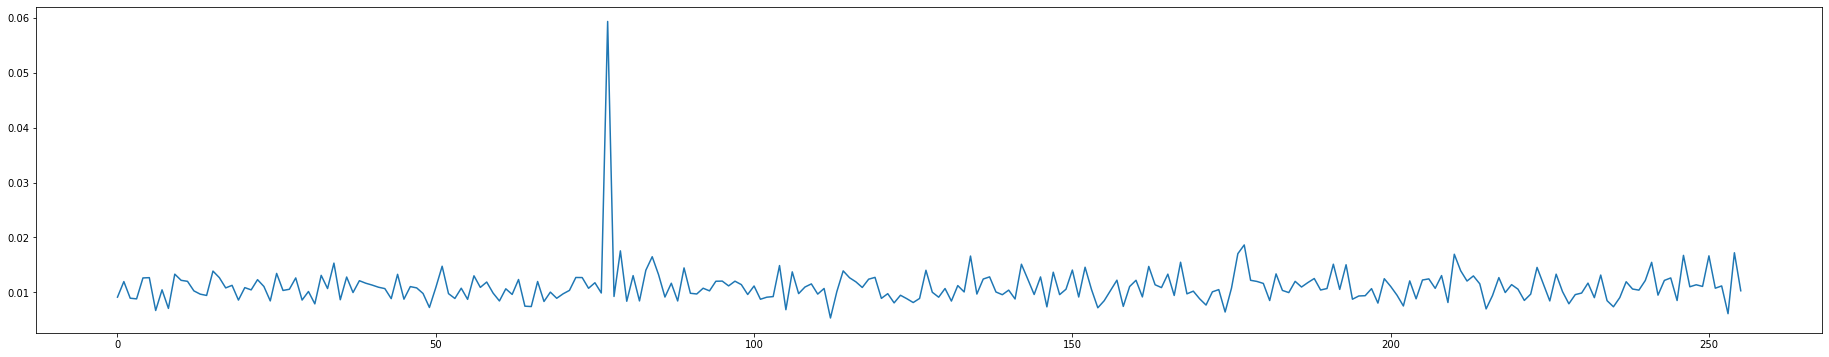



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [54]:
AnalyzedKey = []

for targetByte in range(2, 3):
    key, Ratio, KeyCorrs, MaxPeak = test(so_simul_trace_normal, simul_pt, 0)
    AnalyzedKey.append(key)

    print("Analyzed Key        : {}".format(hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_simul_trace_normal[0]))
    p.line(x_range, so_simul_trace_normal[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:14<00:00,  3.44it/s]

Analyzed Key        : 0x6d
Ratio               : [1.057754903356985]
Max Correlation     : 0.018328802769746248


[ MaxPeak Figure ]


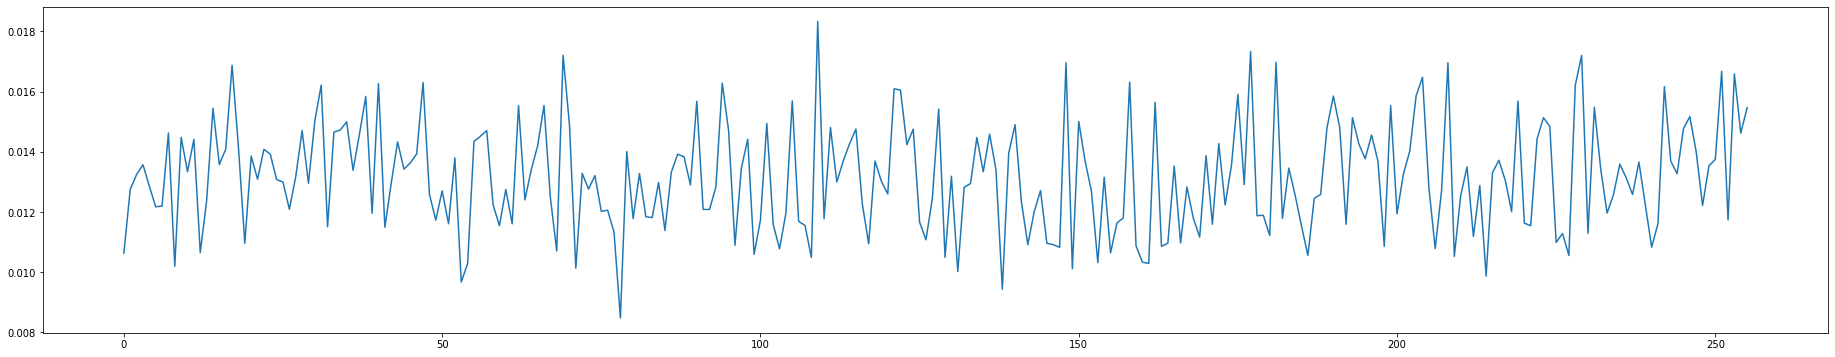



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [55]:
AnalyzedKey = []

for targetByte in range(2, 3):
    key, Ratio, KeyCorrs, MaxPeak = test(simul_trace_normal, simul_pt, 0)
    AnalyzedKey.append(key)

    print("Analyzed Key        : {}".format(hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(simul_trace_normal[0]))
    p.line(x_range, simul_trace_normal[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

In [58]:
def FO_test(trace, plain, bit):
    KeyCorrs  = []
    MaxPeak   = []
    Ratio     = []

    corrs    = []
    maxCorrs = []
    for GuessKey in tqdm(range(256)):
        IntermediateValue = HW[np.array(Sbox)[(plain[:, 0] ^ GuessKey).astype(int)]]
        IntermediateValue = IntermediateValue.reshape(50000, 1)
        corr = np.abs(correlation(trace, IntermediateValue))
        corrs.append(corr)
        maxCorrs.append(np.max(corr))
    key        = np.argmax(maxCorrs)
    RankedCorr = np.sort(maxCorrs)
    
    KeyCorrs.append(corrs)
    MaxPeak.append(maxCorrs)
    Ratio.append(RankedCorr[-1] / RankedCorr[-2]) 
        
    return key, Ratio, KeyCorrs, MaxPeak

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:16<00:00,  3.34it/s]

Analyzed Key        : 0x42
Ratio               : [1.0417033884260722]
Max Correlation     : 0.01930312572996662


[ MaxPeak Figure ]


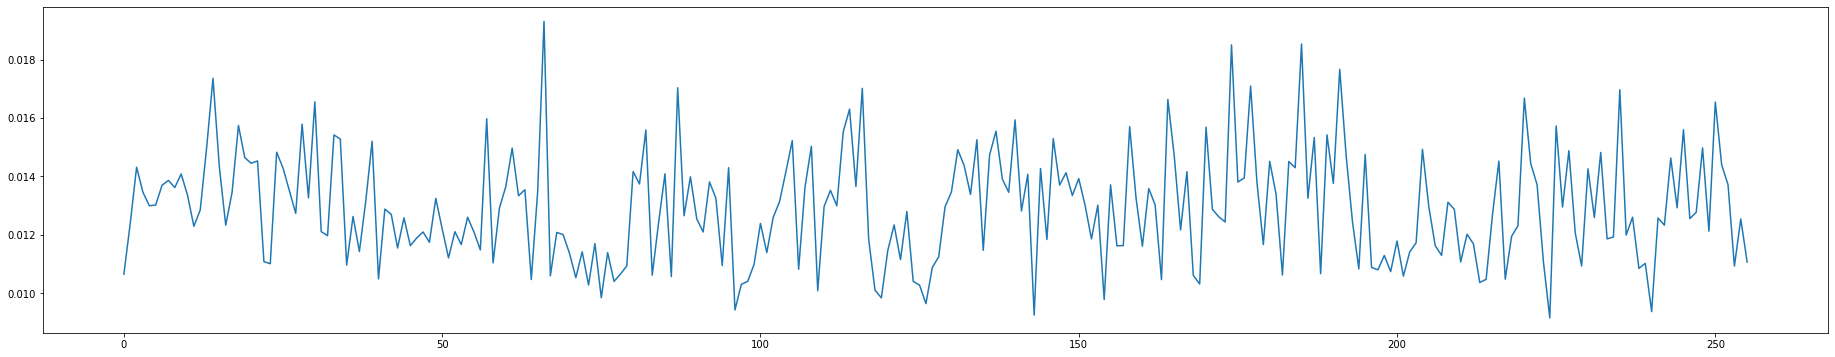



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [61]:
AnalyzedKey = []

for targetByte in range(2, 3):
    key, Ratio, KeyCorrs, MaxPeak = FO_test(simul_trace_normal, simul_pt, 0)
    AnalyzedKey.append(key)

    print("Analyzed Key        : {}".format(hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(simul_trace_normal[0]))
    p.line(x_range, simul_trace_normal[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

In [13]:
target_byte = 2
All_difference = []

def simul_analysis_MLP_AT(m, Init, traces, pts, tr_num, num_keycandi, result_type, num_epochs, batch_size, right_key):
    right_candi = 0
    right_candida = 0
    accuracies = []
    b_accuracies = []
    losses     = []
    
    best_acc = 0
    best_loss = 100
    
    for k in tqdm(range(num_keycandi)):
        m.set_weights(Init)
        
        hypothesis = np.array(Sbox)[(pts[:, 0] ^ ((0xaaff + k) & 0xff)).astype(int)] ^ np.array(Sbox)[(pts[:, 1] ^ ((0xaaff + k) >> 8)).astype(int)]
        #hypothesis = np.array(Sbox)[(pts[:] ^ k).astype(int)]
        #target = sum([hypothesis & (1 << i) > 0 for i in range(8)])
        #target = keras.utils.to_categorical(target, 9)
        #target = ((hypothesis >> 7) & 1).astype(float)
        target = (hypothesis & 1).astype(float)
        #target = keras.utils.to_categorical(target, 2)
        #target = np.array([(hypothesis & 1).astype(float), ((hypothesis & 2) >> 1).astype(float),((hypothesis & 4) >> 2).astype(float),((hypothesis & 8) >> 3).astype(float),((hypothesis & 16) >> 4).astype(float),((hypothesis & 32) >> 5).astype(float),((hypothesis & 64) >> 6).astype(float),((hypothesis & 128) >> 7).astype(float)])
        #target = np.transpose(target)
        #target = np.reshape(target, (traces.shape[0], 8))
        
        m.fit(x = traces, y = target, epochs = num_epochs, batch_size = batch_size, verbose = 0)
        
        accuracies.append(m.history.history['accuracy'])
        if best_acc < m.history.history['accuracy'][num_epochs - 1]:
            best_acc = m.history.history['accuracy'][num_epochs - 1]
            right_candi = k
        
        losses.append(m.history.history['loss'])
        if best_loss > m.history.history['loss'][num_epochs - 1]:
            best_loss = m.history.history['loss'][num_epochs - 1]
            right_candida = k
    
    last_val = []
    for t in range(num_keycandi):
        last_val.append(accuracies[t][num_epochs - 1])
    sort = pd.Series(last_val)
    IQR = sort.quantile(.75) - sort.quantile(.25)
    thrs = np.full((1, num_epochs) , sort.quantile(.75) + 1.5 * IQR)
    ratio = ((accuracies[right_candi][num_epochs - 1] - sort.quantile(.75)) / IQR) / 1.5
    print("Right candidate: ", hex(right_candi))
    print("Ratio: ", ratio)

    plt.figure(figsize = (16, 6))
    for k in range(0, right_candi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    for k in range(right_candi + 1, num_keycandi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    plt.plot(thrs[0], color = 'blue', label = 'threshold')
    plt.plot(accuracies[~right_candi], color = 'black', label = 'wrong key')
    plt.plot(accuracies[right_candi], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    last_val = []
    for t in range(num_keycandi):
        last_val.append(losses[t][num_epochs - 1])
    sort = pd.Series(last_val)
    IQR = sort.quantile(.75) - sort.quantile(.25)
    thrs = np.full((1, num_epochs) , sort.quantile(.25) - 1.5 * IQR)
    ratio = ((sort.quantile(.25) - losses[right_candida][num_epochs - 1]) / IQR) / 1.5
    print("Right candidate: ", hex(right_candida))
    print("Ratio: ", ratio)
    
    plt.figure(figsize = (16, 6))
    for k in range(0, right_candida - 1):
        plt.plot(losses[k], color = 'black', label = None)
    for k in range(right_candida + 1, num_keycandi - 1):
        plt.plot(losses[k], color = 'black', label = None)
    plt.plot(thrs[0], color = 'blue', label = 'threshold')
    plt.plot(losses[~right_candida], color = 'black', label = 'wrong key')
    plt.plot(losses[right_candida], color = 'red', label = 'right key')
    plt.legend()
    plt.show()

In [14]:
class Stretch_Sigmoid(layers.Activation):
    def __init__(self, activation, **kwargs):
        super(Stretch_Sigmoid, self).__init__(activation, **kwargs)
        self.__name__ = 'stretch_sigmoid'

def stretch_sigmoid(x, beta=0.1):
    return K.sigmoid(beta * x)

keras.utils.get_custom_objects().update({'stretch_sigmoid': Stretch_Sigmoid(stretch_sigmoid)})

In [15]:
def build_MLP_1(points_len):
    input_layer = layers.Input(shape = (points_len, ))
    bat_input = layers.BatchNormalization()(input_layer)
    #attention_probs_1 = layers.Dense(points_len, activation='softmax')(input_layer)
    #attention_mul_1 = layers.multiply([input_layer, attention_probs_1])
    #Dense_1 = layers.Dense(100, activation = 'relu')(input_layer)
    
    Dense_3 = layers.Dense(100, activation = 'relu')(bat_input)
    y = layers.Dense(1, activation = 'stretch_sigmoid')(Dense_3)

    return tf.keras.Model(inputs=[input_layer], outputs=y)

In [ ]:
with tf.device("/device:GPU:0"):
    train_num = simul_trace_normal.shape[0]
    print(train_num)
    
    print("============= {} =============".format(train_num))
    rand_idx = np.arange(0, train_num) # 반복부분
    np.random.shuffle(rand_idx)
    
    simul_T_attack = simul_trace_normal[rand_idx]
    simul_P_attack = simul_pt[rand_idx]
    
    m = build_MLP_1(simul_trace_normal.shape[1])
    m.summary()
    m.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    Init = m.get_weights()
    
    # 학습 시작 시간 측정
    print("Training started: ", datetime.datetime.now())
    start = time.time()
    
    simul_analysis_MLP_AT(m, Init, simul_T_attack, simul_P_attack, train_num, 64, 'HW', 20, 300, 0xE0)
    
    # 학습 종료 시간 측정 및 소요 시간 계산
    elapsed = time.time() - start
    print("Training ended: ", datetime.datetime.now())
    print("Elapsed", elapsed)

50000
============= 50000 =============
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 700)]             0         
                                                                 
 dense (Dense)               (None, 25)                17525     
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 17,551
Trainable params: 17,551
Non-trainable params: 0
_________________________________________________________________


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Training started:  2022-12-17 12:06:54.848554


 14%|███████████▋                                                                       | 9/64 [02:16<14:01, 15.29s/it]